<a href="https://colab.research.google.com/github/neel26desai/cmpe255_clustering/blob/main/AudioClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/facebookresearch/ImageBind.git
!pip install git+https://github.com/facebookresearch/pytorchvideo.git@28fe037d212663c6a24f373b94cc5d478c8c1a1d timm==0.6.7 ftfy regex einops fvcore decord==0.6.0

Cloning into 'ImageBind'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 112 (delta 43), reused 33 (delta 33), pack-reused 51
Receiving objects: 100% (112/112), 2.64 MiB | 20.78 MiB/s, done.
Resolving deltas: 100% (50/50), done.
  Cloning https://github.com/facebookresearch/pytorchvideo.git (to revision 28fe037d212663c6a24f373b94cc5d478c8c1a1d) to /tmp/pip-req-build-id5ledzu
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorchvideo.git /tmp/pip-req-build-id5ledzu
  Running command git rev-parse -q --verify 'sha^28fe037d212663c6a24f373b94cc5d478c8c1a1d'
  Running command git fetch -q https://github.com/facebookresearch/pytorchvideo.git 28fe037d212663c6a24f373b94cc5d478c8c1a1d
  Running command git checkout -q 28fe037d212663c6a24f373b94cc5d478c8c1a1d
  Resolved https://github.com/facebookresearch/pytorchvideo.git to commit 28fe037d212663c6a

In [1]:
import os

In [2]:
%cd /content/ImageBind/

/content/ImageBind


In [3]:
import imagebind.data
import torch
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# Instantiate model
model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)


100%|██████████| 4.47G/4.47G [00:33<00:00, 144MB/s]


ImageBindModel(
  (modality_preprocessors): ModuleDict(
    (vision): RGBDTPreprocessor(
      (cls_token): tensor((1, 1, 1280), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Sequential(
          (0): PadIm2Video()
          (1): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
        )
      )
      (pos_embedding_helper): SpatioTemporalPosEmbeddingHelper(
        (pos_embed): tensor((1, 257, 1280), requires_grad=True)
        
      )
    )
    (text): TextPreprocessor(
      (pos_embed): tensor((1, 77, 1024), requires_grad=True)
      (mask): tensor((77, 77), requires_grad=False)
      
      (token_embedding): Embedding(49408, 1024)
    )
    (audio): AudioPreprocessor(
      (cls_token): tensor((1, 1, 768), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10), bias=False)
        (norm_layer): LayerNorm((768,), eps=1e-05, elementwise_affine=

In [5]:
import os
audio_paths = []
for folder in os.listdir('/content/drive/MyDrive/sound_data/'):
  for f in os.listdir(f'/content/drive/MyDrive/sound_data/{folder}'):
    audio_paths.append(f'/content/drive/MyDrive/sound_data/{folder}/{f}')


In [7]:
# Load data
inputs = {
 ModalityType.AUDIO: imagebind.data.load_and_transform_audio_data(audio_paths, device)
}

In [8]:
#generating the embeddings
with torch.no_grad():
 embeddings = model(inputs)

In [15]:
del model

In [17]:
import gc
gc.collect()

253

In [9]:
embeddings['audio'].shape

torch.Size([300, 1024])

In [19]:
torch.cuda.empty_cache()

In [20]:
#converting the embeddings to cpu format so that we can use sklearn on
embeddings_cpu=embeddings['audio'].to('cpu').numpy()

In [21]:
from sklearn.cluster import KMeans

In [22]:
# Define the number of clusters
n_clusters = 3 # the audio files are in 3 different languages

# Perform KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

In [23]:
clusters = kmeans.fit_predict(embeddings_cpu)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


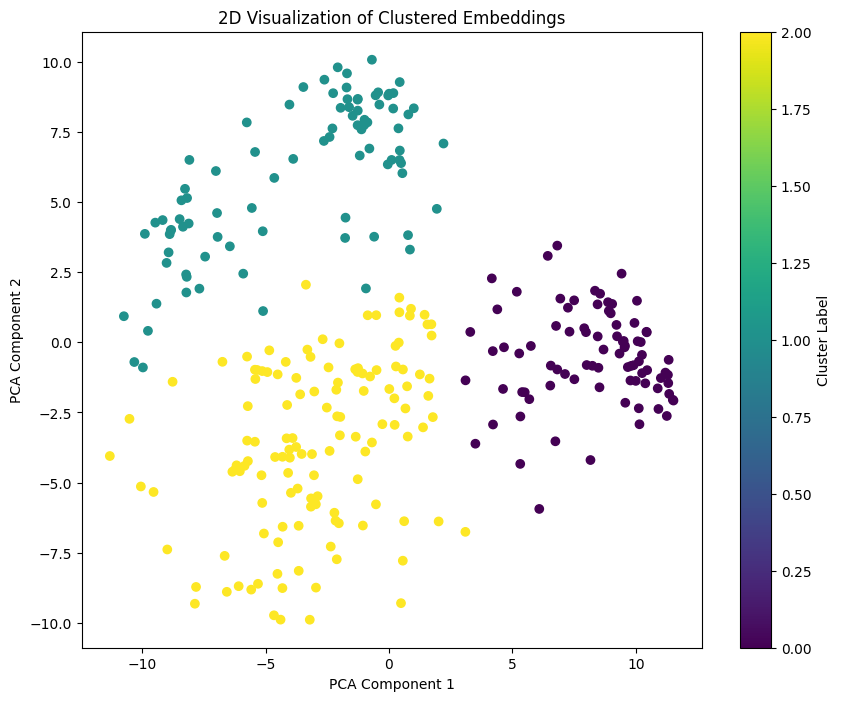

In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Use PCA to reduce the dimensionality of the embeddings to 2D for visualization
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_cpu)

# Plot the embeddings with cluster labels
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title('2D Visualization of Clustered Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()


In [25]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Calculate cluster quality metrics
silhouette_avg = silhouette_score(embeddings_cpu, clusters)
davies_bouldin = davies_bouldin_score(embeddings_cpu, clusters)
calinski_harabasz = calinski_harabasz_score(embeddings_cpu, clusters)

silhouette_avg, davies_bouldin, calinski_harabasz


(0.17632788, 2.2437717331514238, 49.02691477574796)